# Inverse Limit Interactive Visualizer

Created by Alan Bertl in 2020.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
            });
        }
    );
</script>

In [3]:
%%html
<script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
        $('div.input').hide();
        } else {
        $('div.input').show();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.

## Code

In [4]:
import numpy as np
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.figure import Figure
from operator import le as less_eq
from itertools import tee

In [5]:
def adj_pairs(it):
    itr = iter(it)
    a = next(itr)
    for b in itr:
        yield a,b
        a = b

In [6]:
def issorted(it, compare = less_eq):
    a,b = tee(it)
    return all(map(compare,a,b))

In [7]:
def rev_enumerate(seq):
    return zip(range(len(seq)-1,-1,-1),reversed(seq))

In [8]:
class BondingMap(object):
    def __init__(self, domains, ms, bs):
        """
        domains: Domain partition for the piecewise defined function.  
        
        ms: Slopes for each subdomain.

        bs: Constants for each subdomain.
        """
        assert issorted(domains) and domains[0] == 0.0 and domains[-1] == 1.0, \
            "Invalid domain partition.  Must begin with 0.0 and end with 1.0 and be in increasing order."
        assert len(domains)-1 == len(ms) == len(bs), \
            "Parameter and partition lengths don't match."
            
        self.domains = domains
        
        self.starts = np.array(domains[:-1])[...,None]
        self.ends = np.array(domains[1:])[...,None]
        self.ms,self.bs = np.array(ms)[...,None],np.array(bs)[...,None]
    
    def __call__(self,x):
        """ Apply the bonding map to x. """
        return np.choose(
            np.argmax(
#                 ((self.starts <= x) & (x < self.ends)) | (x == self.ends * (2*np.eye(*self.ends.shape)[::-1] - np.ones_like(self.ends))),
                (self.starts <= x) & (x <= self.ends),
                axis=0
            ),
            x*self.ms+self.bs,
        )


In [9]:
class Limit(object):
    """
    Limit class for visualization of inverse limits on the Hilbert cube.  Candidates
    must be obtainable using finitely piecewise linear bonding maps.
    """
    
    # Some constants defining different scaling rates.
    GEOMETRIC = 'geometric'
    HARMONIC = 'harmonic'
    
    def __init__(self, fs, repeats=True, iterations=5, coord_met_dec=HARMONIC):
        """
        fs: A list of BondingMap objects representing the bonding maps of the limit.
        
        repeats: Flag indicating whether a single bonding map should be used repeatedly.
        If false, it is assumed all the bonding maps were given individually.
        
        iterations: In the case repeats == True, the number of iterations to apply to
        the given bonding maps.  If several bonding maps were given, they will all be 
        repeated <iterations> many times.  If repeats == False, this is ignored.
        
        coord_met_dec: Specifies the rate at which the Hilbert cube metric evaluation
        decreases as coordinates increase.  There's not a whole lot of qualitative or
        computational complexity difference between options, but the plots do change
        noticeably.  I've made harmonic the default because I think the plots are more
        clear.
        """
        for f in fs:
            assert isinstance(f,BondingMap)
        
        if coord_met_dec == Limit.GEOMETRIC:
            self.scale_f = lambda i:2**i
        elif coord_met_dec == Limit.HARMONIC:
            self.scale_f = lambda i:i+1
        else: 
            raise NameError(f"Scaling rate {coord_met_dec} is not recognized.")
        
        self.fs = fs*iterations if repeats else fs
        self.n = n = len(self.fs) # length of the sequence for our approximation.
        
        # We need a pair of orthogonal vectors that will give us a 2-d view of
        # n+1 space.  Some views are better than others, but I chose a view
        # that keeps information about all coordinates and favors the first.
        # The criteria I used are:
        # - all coordinates of both vectors are non-zero
        # - orthanogality, i.e. np.dot(p,q) == 0 (up to rounding error)
        # - leading coordinate of each has largest magnitude (except in the edge case n=1).
        self.p = np.ones(n+1)
        self.p[0] = 2.0
        self.p[-1] = -1.0
        
        self.q = (3.0/(n+4.0)) * np.ones(n+1)
        self.q[0] = (-2.0 * n - 2.0)/(n + 4.0)
        self.q[1] = (n + 7.0)/(n + 4.0)
        self.q[-1] = -self.q[-1]
        
        # Getting the vectors can be computationally intensive, so we'll
        # generate them when make_vects() is called.
        self.vects_computed = False
        self.vects = None
    
    def make_vects(self):
        """
        Generate the vectors needed to plot the visualization.
        """
        partition = self.fs[0].domains
        for f in self.fs[1:]:
            inv_images = (partition - f.bs) / f.ms
            partition = np.unique(
                np.concatenate([
                    inv_images[(f.starts <= inv_images) & (inv_images <= f.ends)],
                    f.starts.flatten(),
                    f.ends.flatten()
                ])
                
            )
        
        # The fruit of our labor is a domain partition in every coordinate that is granular enough
        # so that each domain in the i+1st coordinate maps into exactly one domain in the ith 
        # coordinate.  That means if we map any given domain in the last coordinate up all the way
        # to the leading coordinate, the image in n dimensional space is a line segment.  This in 
        # turn means we can plot it by just joining adjacent vertices -- vertices which are 
        # obtained, in order, by mapping each dividing point in the nth coordinate in numerical order
        # successively through every coordinate using the appropriate bonding map to obtain the 
        # coordinates of a point in n+1-space.  So that's what we'll do, and store them in vects.
        vects_lst = [partition]
        v = partition
        for i,f in rev_enumerate(self.fs):
            vects_lst.append(f(vects_lst[-1]))
        vects = np.stack(vects_lst[::-1], axis=-1)
        for i in range(vects.shape[1]):
            vects[:,i] /= self.scale_f(i)

            # For our inverse limit to turn out looking right, we need to scale the coordinates to 
            # enforce the Hilbert cube metric (the scale of the ith coordinate decreases with i).  
            # A full explanation is outside the scope of this demonstration, but 
            # https://en.wikipedia.org/wiki/Hilbert_cube provides a brief synopsis.  Note we scale 
            # *after* we've hit the value with the bonding map, since the bonding maps are defined 
            # on the unscaled domain.
        
        # Note these aren't points to use for plots, they are in a high dimensional space.
        self.vects_computed = True
        self.vects = np.asarray(vects)
        
        # Project the points into 2-d space using the vectors we created in __init__.
        self.xs = np.dot(self.vects, self.p)
        self.ys = np.dot(self.vects, self.q)
        
        # Now put it all together as a sequence of ordered pairs and store it in the class.
        self.vs = np.stack([self.xs,self.ys],-1)
        self.partition = partition
        return self.vs


In [10]:
dragging = None

def onclick(event):
    global dragging
    for i,pt in enumerate(point_list):
        if dragging is not None: return
        contains, attrd = pt.contains(event)
        if not contains: continue
        dragging = (i,pt)

def onmove(event):
    if dragging is not None:
        if not ((0. <= event.xdata <= 1.) and (0. <= event.ydata <= 1.)): return
        i,pt = dragging
        if 0 < i < len(point_list) - 1:
            pt.center = (event.xdata, event.ydata)
        else:
            pt.center = (pt.center[0], event.ydata)
        cur_xdata = line.get_xdata()
        cur_ydata = line.get_ydata()
        line.set_xdata(cur_xdata[:i] + [pt.center[0]] + cur_xdata[i+1:])
        line.set_ydata(cur_ydata[:i] + [pt.center[1]] + cur_ydata[i+1:])
        update_limplot()

def update_limplot():
    cur_xdata = line.get_xdata()
    cur_ydata = line.get_ydata()

    y0s = np.array(cur_ydata[:-1])
    y1s = np.array(cur_ydata[1:])

    x0s = np.array(cur_xdata[:-1])
    x1s = np.array(cur_xdata[1:])

    ms = (y1s - y0s)/(x1s - x0s)
    bm = BondingMap(
        cur_xdata, # domains
        ms, # ms
        -ms * x0s + y0s, # bs
    )
    lim = Limit([bm], iterations = 10)
    x,y = lim.make_vects().T
    invlim.set_xdata(x)
    invlim.set_ydata(y)
    lim_plot.set_xlim(x.min(), x.max())
    lim_plot.set_ylim(y.min(), y.max())
    

def onrelease(event):
    global dragging
    dragging = None

## Interactive

<IPython.core.display.Javascript object>


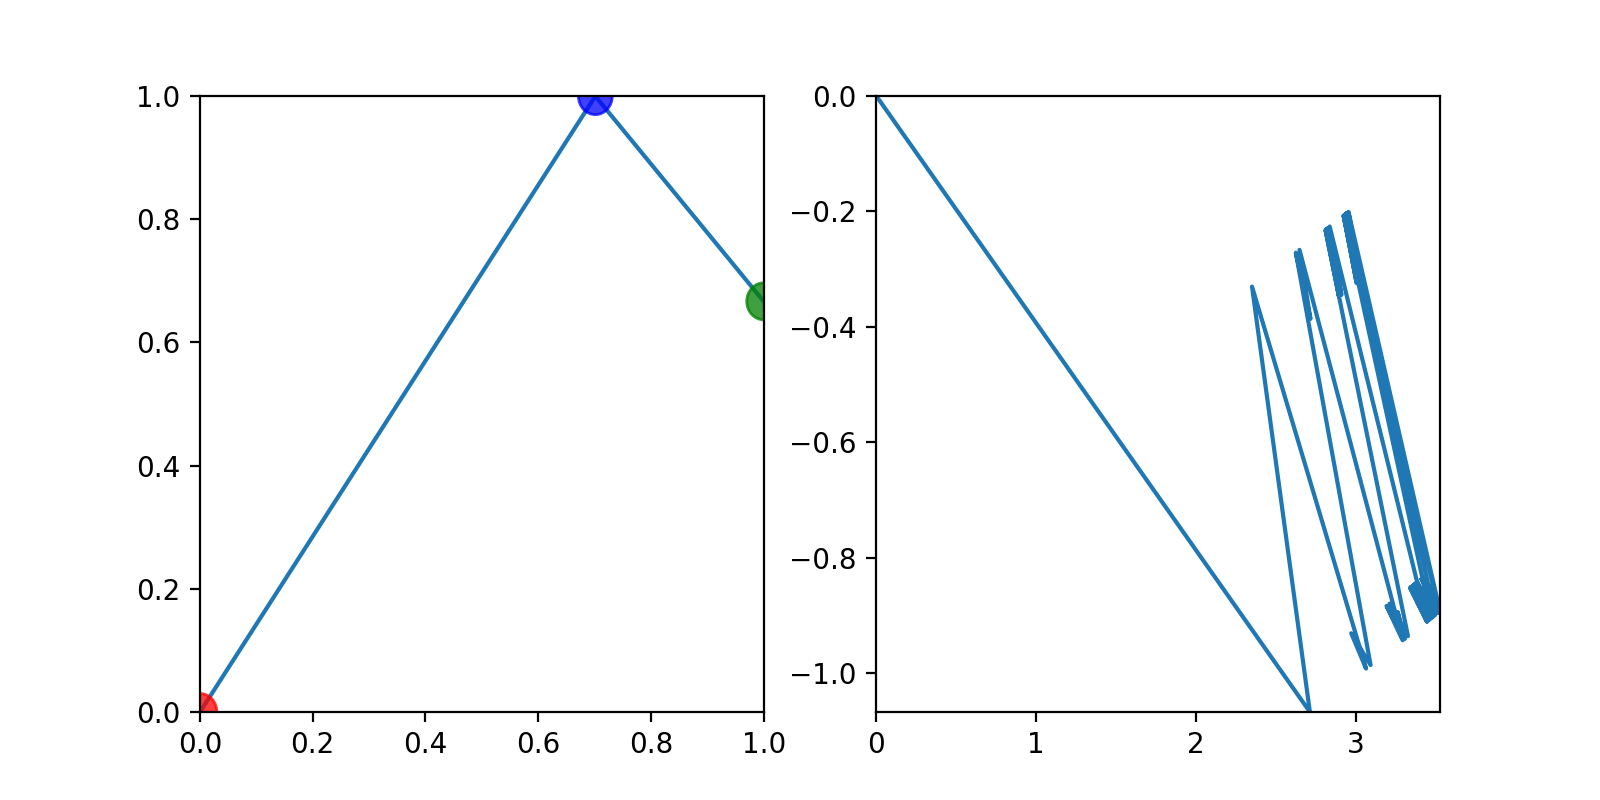

In [11]:
fig = plt.figure(figsize=(8,4), num='Interactive feature map')

bmap_plot = fig.add_subplot(1, 2, 1)
lim_plot = fig.add_subplot(1, 2, 2)

bmap_plot.set_xlim(0.,1.)
bmap_plot.set_ylim(0.,1.)

point = patches.Circle((0., 0.), radius=0.03, fc='r', alpha=0.75, edgecolor='r', zorder=2)
point2 = patches.Circle((2/3, 1.), radius=0.03, fc='b', alpha=0.75, edgecolor='b', zorder=2)
point3 = patches.Circle((1., 2/3), radius=0.03, fc='g', alpha=0.75, edgecolor='g', zorder=2)

point_list = [point, point2, point3]

line = Line2D([pt.center[0] for pt in point_list], [pt.center[1] for pt in point_list], zorder=1)

bmap_plot.add_line(line)
bmap_plot.add_patch(point)
bmap_plot.add_patch(point2)
bmap_plot.add_patch(point3)

invlim = Line2D([], [])

lim_plot.add_line(invlim)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid2 = fig.canvas.mpl_connect('button_release_event', onrelease)
cid3 = fig.canvas.mpl_connect('motion_notify_event', onmove)

update_limplot()